In [1]:
%matplotlib inline

### Pass heat maps
Make a heat map of all teams passes during a tournament. In order to add context, we set a window for danger passes to be those in 15 seconds leading up to a shot.

In [2]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

### Opening the dataset
To get games by Sweden Women's team we need to filter them in a dataframe - if they played as a home or away team. We also calculate number of games to normalize the diagrams later on

In [3]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

#our team
team = "Sweden Women's"

#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()

#calculate number of games
no_games = len(match_ids)

In [4]:
print(no_games)

7


In [5]:
print(match_ids)

[22944, 68345, 69163, 69301, 69208, 22973, 69284]


### Finding danger passes
First, for each game using mplsoccer parser we open the event data. Note that we use the [0] to store only event data. Then, for each period in the game we take out shots by England and accurate passes by England that were not set pieces. We look for the passes 15 seconds before a shot. That is why we iterate for different periods. If a shot was made in 46th minute and there were 3 additional minutes in the first half, we would include those passes. Having the danger passes we concatenate them with a pandas dataframe to store danger passes from all games

In [6]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game 
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull()) 
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        #keep only Shots by England in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15  
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
        
        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period])

In [7]:
print(danger_passes)

          x     y  end_x  end_y  minute  second                    player_name
662    68.9  52.0   62.3   41.0      17      41                  Nilla Fischer
665    62.3  37.5   66.0   25.2      17      43        Linda Brigitta Sembrant
668    68.0  24.2   78.5    7.3      17      45            Sara Caroline Seger
671    77.9   7.3  110.7    9.4      17      47       Magdalena Lilly Eriksson
675   117.4  23.3  110.0   47.1      17      53        Emma Stina Blackstenius
...     ...   ...    ...    ...     ...     ...                            ...
3456   93.4  47.4   96.8   56.3      92      23  Olivia Alma Charlotta Schough
3459   96.8  56.3  105.7   69.4      92      25               Kosovare Asllani
3462  107.4  69.1  106.4   44.6      92      26  Elin Ingrid Johanna Rubensson
484    94.7  41.7  108.8   52.4      12      38            Eva Sofia Jakobsson
3084   95.4  25.9   89.0   31.4      93      33        Emma Stina Blackstenius

[169 rows x 7 columns]


### Plotting location of danger passes
First, we create a pitch using mplsoccer Pitch class. Then we scatter them using scatter method. If you want to investigate the direction of passes, uncomment a line below!

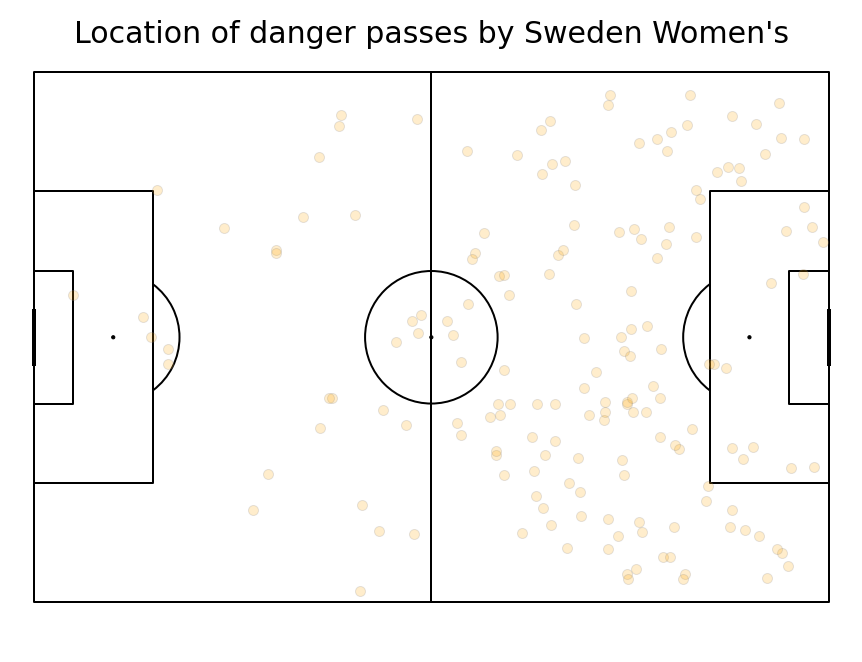

In [11]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='orange', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])

#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)

plt.show()

### Making a heat map
To make a heat map, first, we draw a pitch. Then we calculate the number of passes in each bin using bin_statistic method. Then, we normalize number of passes by number of games. We plot a heat map and then, we make a legend. As the last step, we add the title.

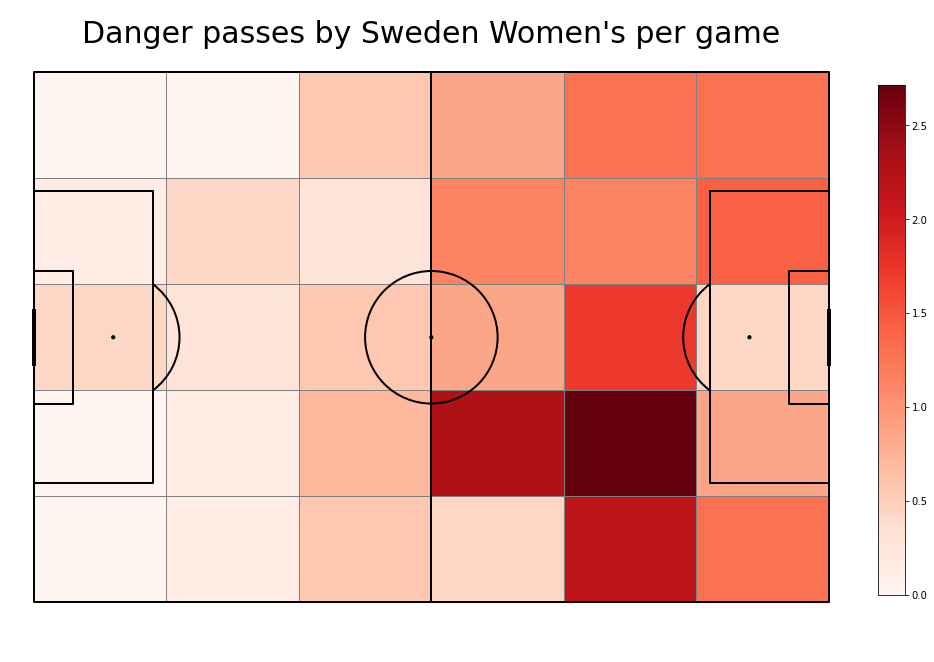

In [12]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#get the 2D histogram 
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)

#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)

plt.show()

### Making a diagram of most involved players
To find out who was the most involved in dnager passes, we keep only surnames of players to make the vizualisation clearer. Then, we group the passes by the player and count them. Also, we divide them by number of games to keep the diagram per game. As the last step, we make the legend to our diagram.

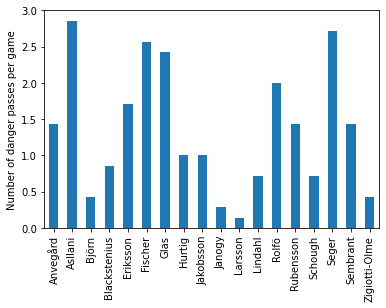

In [13]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()